# 6.5: Linear Model Selection and Regularization Exercises

### Getting Started

#### Import Libraries 

We import our standard libraries and specific objects/libraries at the top level of our notebook.

In [1]:
# Import libraries and objects
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from sklearn.linear_model import ElasticNetCV, ElasticNet
from functools import partial
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
# !pip install l0bnb > nul 2>&1 # "> nul 2>&1" means that the install messages have been surpressed
from l0bnb import fit_path
import matplotlib.pyplot as plt

import warnings

# Suppress FutureWarning in ISLP.models.columns
# The warning is related to Series.__getitem__ treating keys as positions, which is deprecated.
# Since ISLP is an external library that I don't control, and this specific warning does not
# affect my current usage, I'm suppressing it to keep the output clean and focused on relevant information.
warnings.filterwarnings(action='ignore', category=FutureWarning, module='ISLP.models.columns')

We will be using the `Hitters` data set in the `ISLP` package. It contains information about a baseball player’s `Salary`
along with other information about their performance in the previous year.

The `Salary` variable is missing for some of the players. The `np.isnan()` function can be used to identify the missing observations. It returns an array of the same shape as the input vector, with a `True` for any elements that are missing, and a `False` for non-missing elements. The `sum()` method can then be used to count all of the missing elements.

In [2]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()

59

The `dropna()` method of data frames removes all of the rows that have missing values in any variable.

In [3]:
Hitters = Hitters.dropna();
Hitters.shape

(263, 20)

### Subset Selection & Deciding Between Models Using the Validation Set Approach and Cross-Validation
#### Best Subset Selection & Stepwise Selection

We first choose the best model using forward selection based on $C_p$. This score
is not built in as a metric to `sklearn`, so we have to define the function ourselves.

In [4]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

neg_Cp = partial(nCp, sigma2)

In [ ]:
#  Find model that will return lowest Cp

We can now use `neg_Cp()` as a scorer for model selection. Along with a score we need to specify the search strategy. This is done through the object `Stepwise()` in the `ISLP.models` package, using the method `Stepwise.first_peak()`.

In [5]:
# For fixed number of steps of stepwise search
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

We now fit a linear regression model with `Salary` as outcome using forward
selection. To do so, we use the function `sklearn_selected()`  from the `ISLP.models` package.

In [6]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [7]:
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

As an  alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a
method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()` estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models`
computes the cross-validated predictions for each of the models along the path, which we can use to evaluate the cross-validated MSE along the path.

In [8]:
# Define path
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

# Fit the full forward-selection path
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

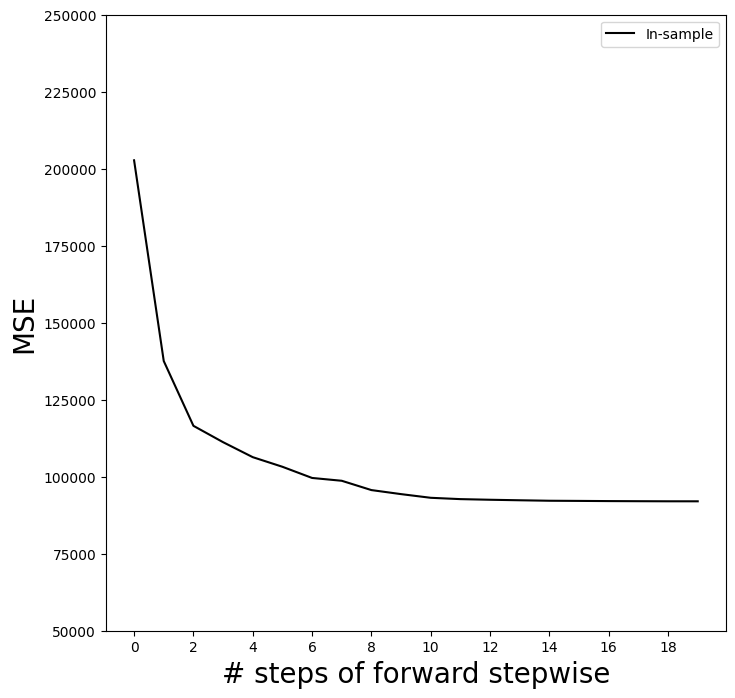

In [9]:
# Compare the cross-validation and validation set MSE
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);

In [ ]:
# So we better make 8-10 predictors so it will be less expensive 
# Less expensive, easier to interpret, less overfitted

We are now ready to use cross-validation to estimate test error along the model path. We must use only the training observations to perform all aspects of model-fitting - including variable selection.

We now compute the cross-validated predicted values using 5-fold cross-validation.

In [11]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(263, 20)

In [12]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

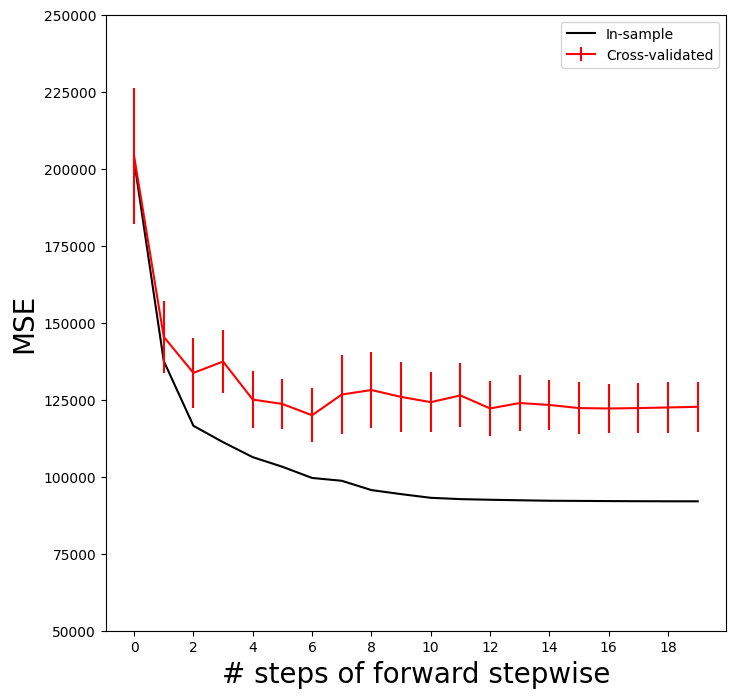

In [13]:
# Add cross validation error estimates 
ax.errorbar(np.arange(n_steps), 
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

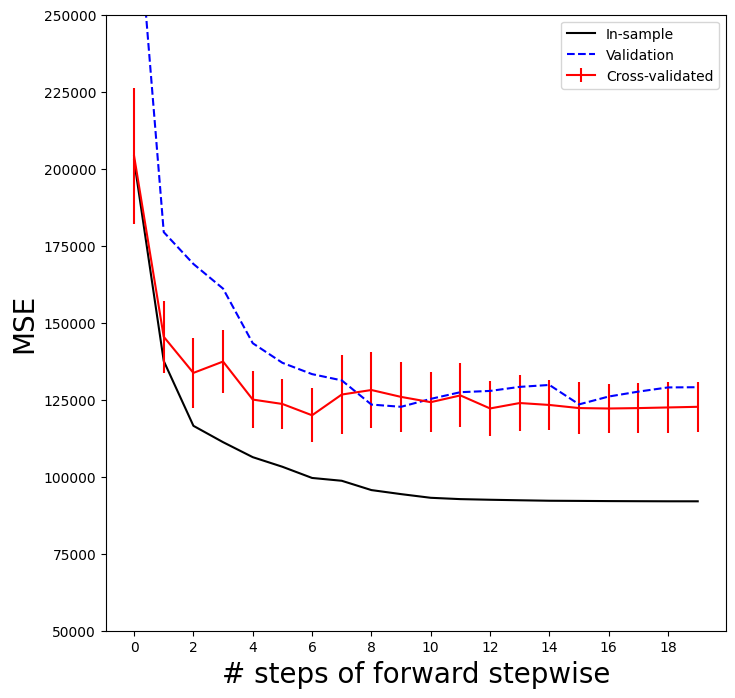

In [14]:
# Repeat using the validation set approach
validation = skm.ShuffleSplit(n_splits=1, 
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

# Plot
ax.plot(np.arange(n_steps), 
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

#### Best Subset Selection
We will use a package called `l0bnb` to perform best subset selection on the `Hitters` dataset.

In [ ]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [ ]:
path = fit_path(X,
Y,
max_nonzeros=X.shape[1])

In [ ]:
path[3]

We could make predictions using this sequence of fits on a validation set as a function of `lambda_0`

### Ridge Regression & The Lasso
#### Ridge Regression
We will use the `sklearn.linear_model` package (for which
we use `skl` as shorthand below)
to fit ridge and  lasso regularized linear models on the `Hitters` data.
We start with the model matrix `X` (without an intercept).

We will use the function `skl.ElasticNet()` to fit both  ridge and the lasso.
To fit a *path* of ridge regressions models, we use
`skl.ElasticNet.path()`, which can fit both ridge and lasso, as well as a hybrid mixture.

In [ ]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

In [ ]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

In [ ]:
# Plot
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

We expect the coefficient estimates to be much smaller, in terms of
$\ell_2$ norm, when a large value of $\lambda$ is used, as compared to
when a small value of $\lambda$ is used

In [ ]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

Let’s compute the $\ell_2$ norm of the standardized coefficients

In [ ]:
np.linalg.norm(beta_hat)

In contrast, here is the $\ell_2$ norm when $\lambda$ is 2.44e-01.

In [ ]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

Above we normalized `X` upfront, and fit the ridge model using `Xs`.
The `Pipeline()`  object
in `sklearn` provides a clear way to separate feature
normalization from the fitting of the ridge model itself.

In [ ]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

We show that it gives the same $\ell_2$ norm as in our previous fit on the standardized data.

In [ ]:
np.linalg.norm(ridge.coef_)

#### The Lasso
We now ask whether the lasso can yield
either a more accurate or a more interpretable model than ridge
regression. In order to fit a lasso model, we once again use the
`ElasticNetCV()`  function; however, this time we use the argument
`l1_ratio=1`

In [ ]:
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

In [ ]:
lambdas, soln_array = skl.Lasso.path(Xs, 
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

In [ ]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

The smallest cross-validated error is lower than the test set MSE of the null model
and of least squares

In [ ]:
np.min(tuned_lasso.mse_path_.mean(1))

In [ ]:
# Plot cross-validation error
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)

In [ ]:
tuned_lasso.coef_

The lasso has a substantial advantage over ridge regression
in that the resulting coefficient estimates are sparse. Here we see
that 6 of the 19 coefficient estimates are exactly zero. So the lasso
model with $\lambda$ chosen by cross-validation contains only 13
variables.

As in ridge regression, we could evaluate the test error
of cross-validated lasso by first splitting into
test and training sets and internally running
cross-validation on the training set. We leave
this as an exercise.


**Fit a linear regression model to the data. Compute the test MSE for the linear regression
model. Compare the results from the linear regression, ridge regression, and the lasso. Which
is the best model and why?**

*These exercises were adapted from : James, Gareth, et al. An Introduction to Statistical Learning: with Applications in Python, Springer, 2023.*